In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

a) Implement the evolutionary strategies ES($μ$+$λ$) and ES($μ$,$λ$) discussed in the lecture.

In [217]:
import numpy as np

def ES(mu, lambda_, chrom_len ,eval_func ,dim_size=5 , min_x = -5, max_x = 5, min_s=0, max_s=1, N = 50, K=0.6, plus=True, tau=None, tau0=None):
    """
    Parameters:
    - mu: Number of parents in the population.
    - lambda_: Number of offspring to be generated in each iteration.
    - chrom_len: Length of the chromosome.
    - dim_size: size of dimension.
    - obj_func: Function for evaluating the fitness of a population.
    - N: Number of iterations or generations.
    - min_x, max_x: Minimum and maximum values for the 'xs' part of the population.
    - min_s, max_s: Minimum and maximum values for the 'ss' part of the population.
    - plus: Boolean, whether to use the "plus" strategy for selecting the next generation.
    - K: Scaling factor.
    - tau, tau0: Scaling factors for mutation.

    returns:
    - Best, cost hist, sigmas hist.
    """
    if tau is None:
        tau = K / np.sqrt(2 * chrom_len)
    if tau0 is None:
        tau0 = K / (2 * np.sqrt(chrom_len))

    cost_history = []
    sigmas_history = []

    xs = np.random.uniform(min_x, max_x, (mu, 1, dim_size))
    ss = np.random.uniform(min_s, max_s, (mu, 1, dim_size))
    population = np.hstack((xs, ss))

    scores = eval_func(population[:, 0, :])

    def select_parents(P, scores):
        scores_ = np.atleast_1d(scores.copy()) / scores.sum()
        parent_indices = np.random.choice(
            np.arange(len(scores)),
            size=lambda_,
            replace=True,
            p=scores_,
        )
        return P[parent_indices]

    def mutate(P):
        epsilon0 = np.random.normal(0, tau0, (lambda_, 1))
        epsilon = np.random.normal(0, tau, (lambda_, dim_size)) + epsilon0
        P[:, 1, :] = P[:, 1, :] * np.exp(epsilon)
        P[:, 0, :] = P[:, 0, :] + np.random.normal(0, 1, (lambda_, dim_size)) * P[:, 1, :]

    def replace(P, scores, Pc, c_scores):
        if plus:
            total_scores = np.hstack((scores, c_scores))
            total_P = np.vstack((P, Pc))
            indices = np.argsort(total_scores)[:mu]
            return total_P[indices], total_scores[indices]

        indices = np.argsort(c_scores)[:mu]
        return Pc[indices], c_scores[indices]

    for _ in range(N):
        parents = select_parents(population, scores)
        mutate(parents)
        offspring_scores = eval_func(parents[:, 0, :])
        population, scores = replace(population, scores, parents, offspring_scores)
        cost_history.append((scores.min(), scores.mean(), scores.max()))
        sigmas_history.append(population[:, 1, :][scores.argmin()])

    return population[:, 0, :][scores.argmin()], cost_history, sigmas_history


In [241]:
def sphere(X):
    	return np.sum(X**2, axis=1)

def schwefel(X):
	return 418.9829*len(X) + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

def rastrigin(X):
	return 10*len(X) + np.sum(X**2 - 10*np.cos(2*np.pi*X), axis=1)

def griewank(x):
    return (1 + (x**2).sum(axis=1) / 4000 - np.prod(np.cos(x/np.sqrt(np.arange(1, x.shape[-1] + 1))), axis=1))

def rosenbrock(X):
    y = 100*(X**2 - np.roll(X, -1, axis=1))**2 + (X - 1)**2
    return np.sum(y[:, :-1], axis=1)

In [220]:
def plot_hist(cost_hist, eval_func):
    cost_hist = np.array(cost_hist)
    print(f'Min: {cost_hist[-1][0]}')
    plt.figure(figsize=(15, 5))
    plt.plot(cost_hist[:,0], label='min')
    plt.plot(cost_hist[:,1], label='mean')
    plt.plot(cost_hist[:,2], label='max')
    plt.title(f'{eval_func.__name__}')
    plt.legend()
    plt.show()
def plot_sigmas(sigmas,eval_func):
    plt.figure(figsize=(15, 5))
    plt.title(f'{eval_func.__name__}  Sigmas')
    plt.plot(sigmas)
    plt.show()

In [222]:
p,cost_hist,sigmas_hist = ES(mu=200, lambda_=200, chrom_len=50, dim_size=10, eval_func=sphere, N=1000, plus=True)


Min: 2.5433832789748266e-05


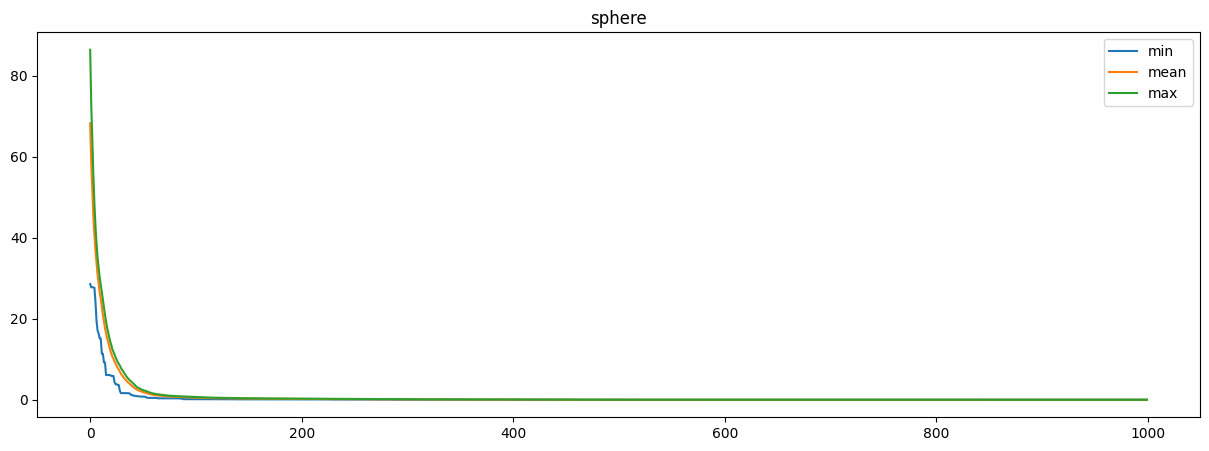

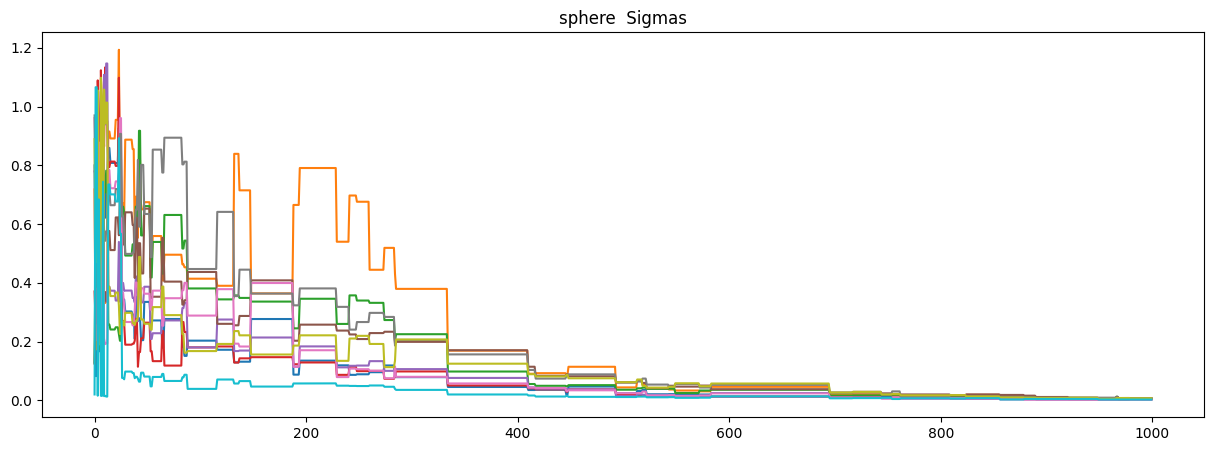

In [223]:
plot_hist(cost_hist, sphere)
plot_sigmas(sigmas_hist, sphere)

b) Review popular benchmarks for global optimisation (http://wwwoptima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO.htm), both
unconstrained and constrained optimisation problems.  
Choose 5 benchmarks
without constraints and use the implemented algorithms to solve them (among the selected benchmarks should include at least one of the following functions:
Griewank Function, Rastrigin Function, Schwefel Function).  
Carefully analyse the performance of the algorithm and the results obtained.  
Check the different settings of the algorithm.
Hint: We are interested in high-dimensional search spaces, i.e. the objective function should have many variables. "Many" here means from tens to hundreds. For lower dimensions, the problem often becomes too trivial and uninteresting.

---


sphere: $f(x) = \sum\limits_{i=1}^d x_i^2$  
rastrigin: $f(x) = Ad+ \sum\limits_{i=1}^d [x_i^2-A\cos(2\pi x_i)]$  
schwefel: $418.9829d-\sum\limits_{i=1}^d x_i\sin(\sqrt{\rvert{x_i}\rvert})$  
griewank: $f(x) = \sum\limits_{i=1}^d ({x_i^2\over 4000}) - \prod\limits_{i=1}^d (\cos({x_i\over\sqrt i})) + 1$  
rosenbrock: $f(x)=\sum\limits_{i=1}^d-1 [100(x_{i+1} - x_i^2)^2 + (x_i -1)^2]$  
trid: $f(x)=\sum\limits_{i=1}^d (x_i -1)^2 - \sum\limits_{i=2}^d x_i x_{i-1}$ 

In [262]:
def _sphere(x):
    return np.sum(x**2)
def _rastrigin(x):
    return (x**2 - 10 * np.cos(2*np.pi * x)).sum() + 10*x.shape[-1]

# def _schwefel(x):
#     alpha = 418.9829
#     n = x.shape[-1]
#     S = x * np.sin(np.sqrt(abs(x)))
#     return alpha * n - np.sum(S)

def _schwefel(x):
    return 418.9829*x.shape[-1] + np.sum(x * np.sin(np.sqrt(np.abs(x))))

def _griewank(x):
    return (1 + (x**2).sum() / 4000 - np.prod(np.cos(x/np.sqrt(np.arange(1, x.shape[-1] + 1)))))

def _rosenbrock(x):
    y = 100*(x**2 - np.roll(x, -1))**2 + (x - 1)**2
    return sum(y[:-1])

In [263]:
def plot_func(n, func):
    n_points = 100
    x_vals = np.linspace(-5, 5, n_points)
    y_vals = np.linspace(-5, 5, n_points)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            point = np.array([X[i, j], Y[i, j]])
            if n > 2:
                point = np.concatenate((point, np.zeros(n-2))) # Extend for higher dimensions
            Z[i, j] = func(point)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Objective Function Value')
    ax.set_title(f'{func.__name__} Function ({n}D)')

    plt.show()


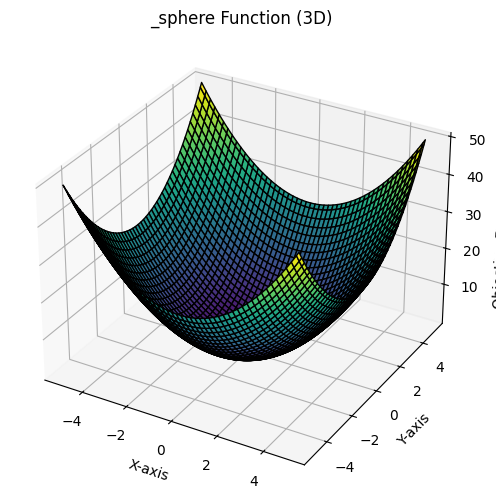

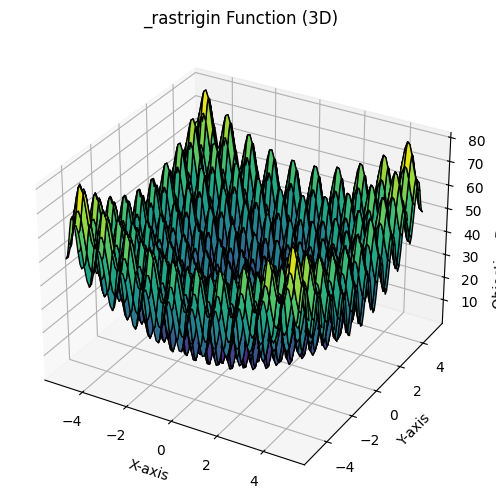

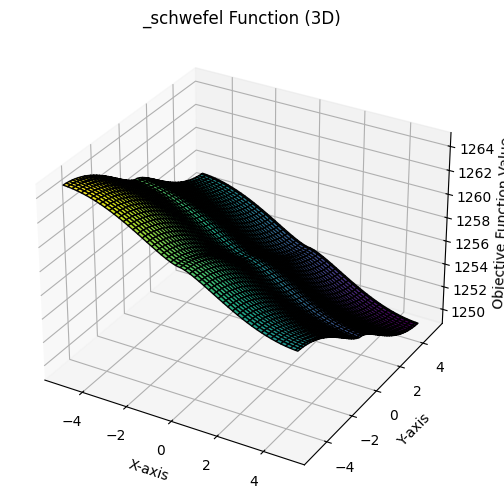

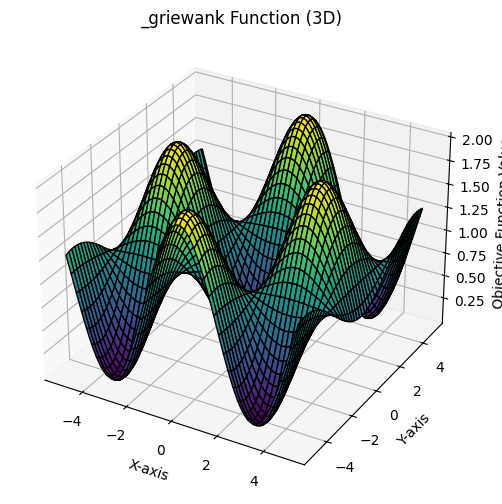

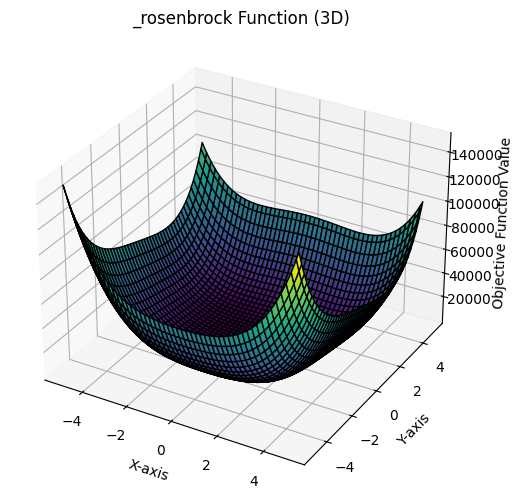

In [257]:
for f in [_sphere, _rastrigin, _schwefel, _griewank, _rosenbrock]:
    plot_func(3, f)

Min: 96.199885006246


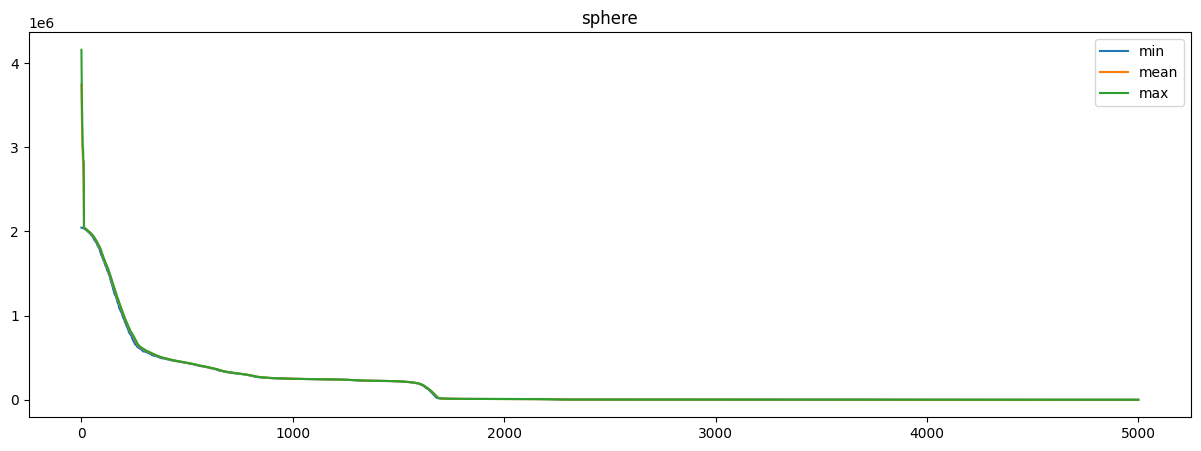

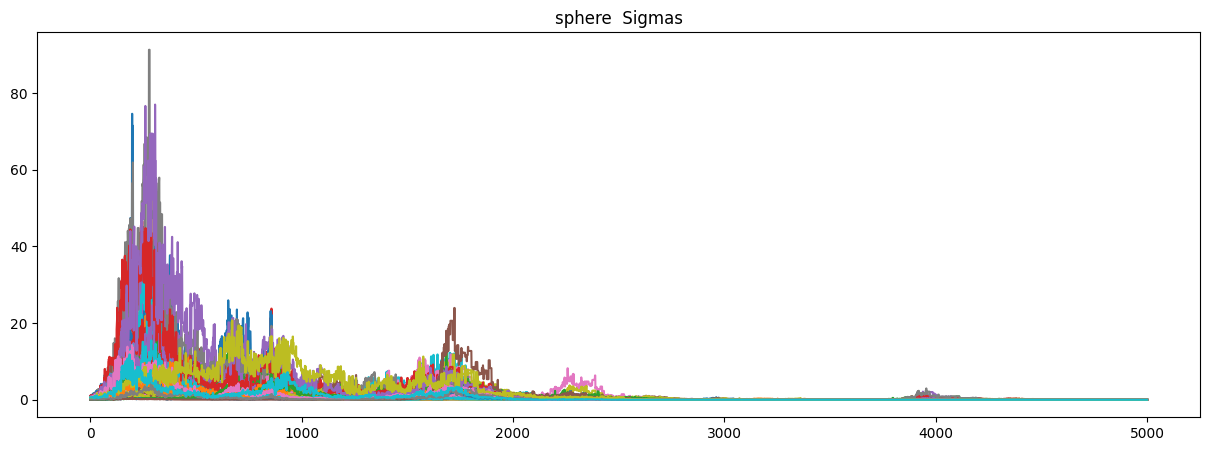

Min: 70013.3509838084


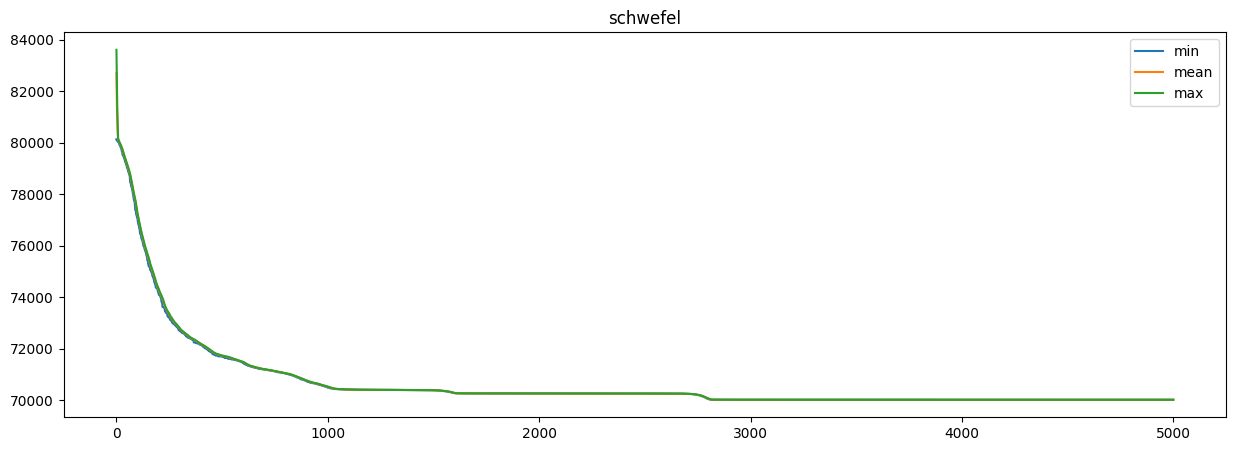

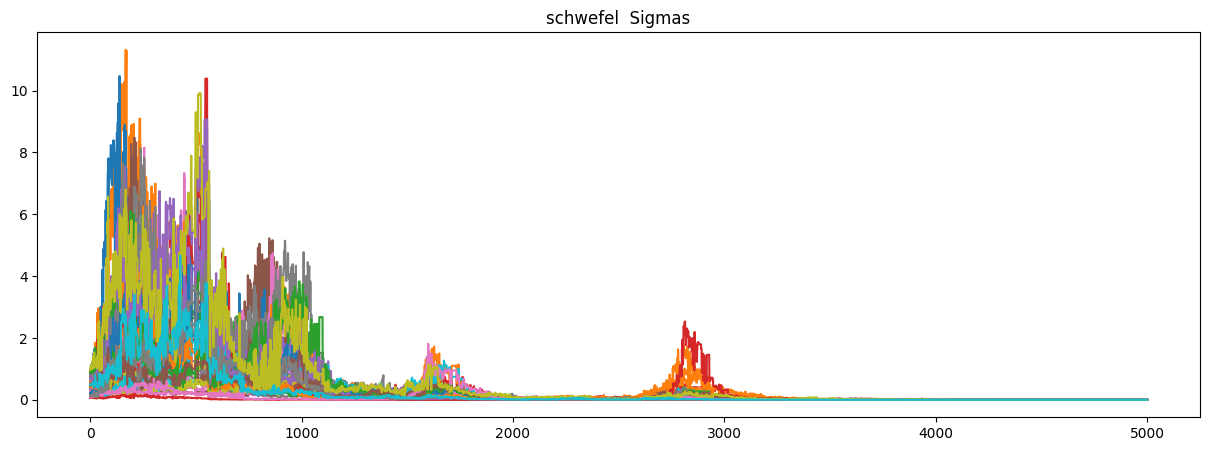

Min: 2418.4638257908064


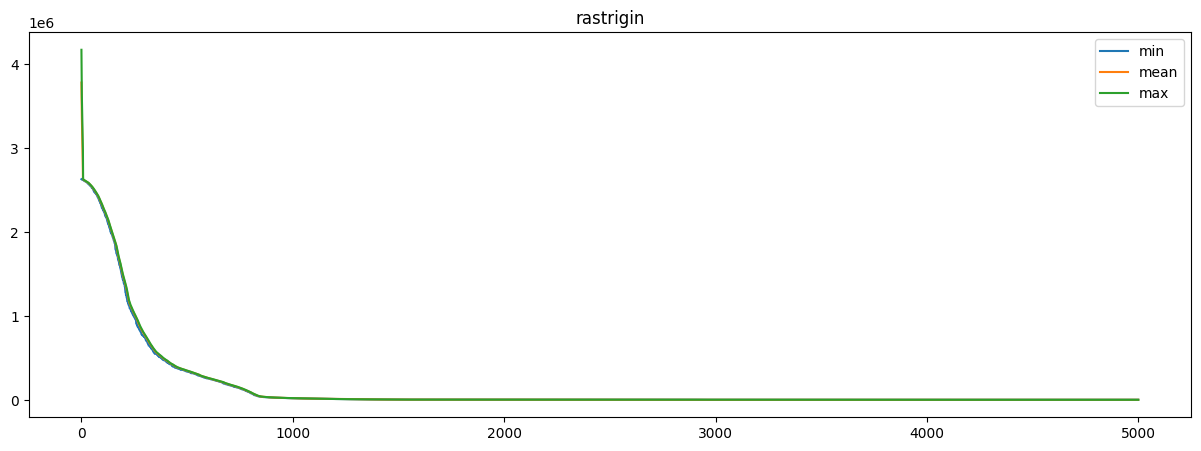

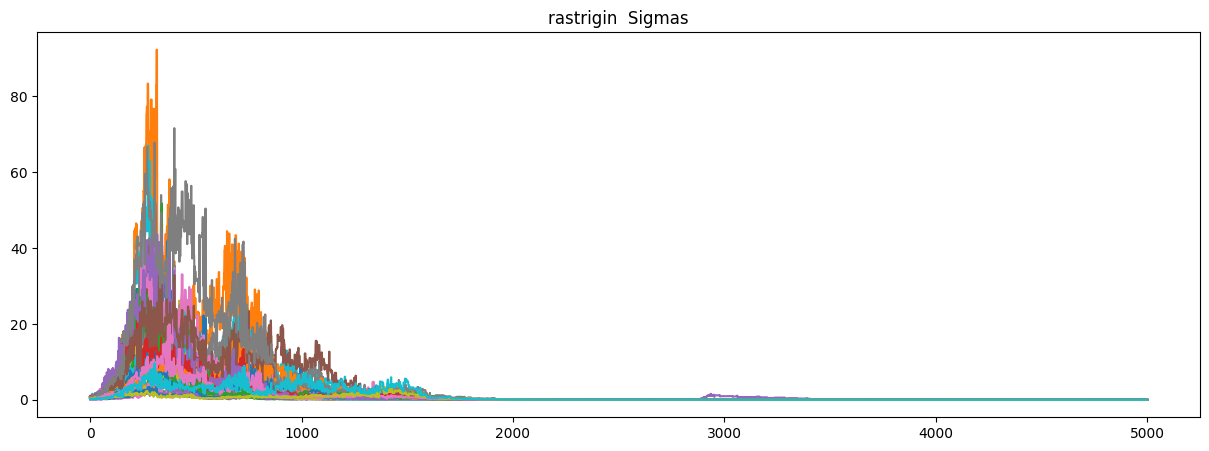

Min: 1.5332706720170186


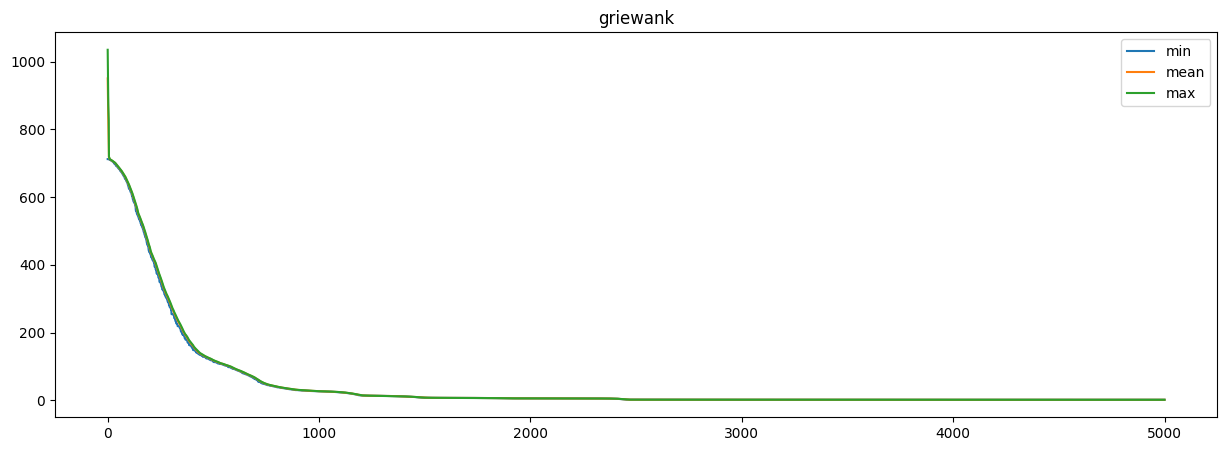

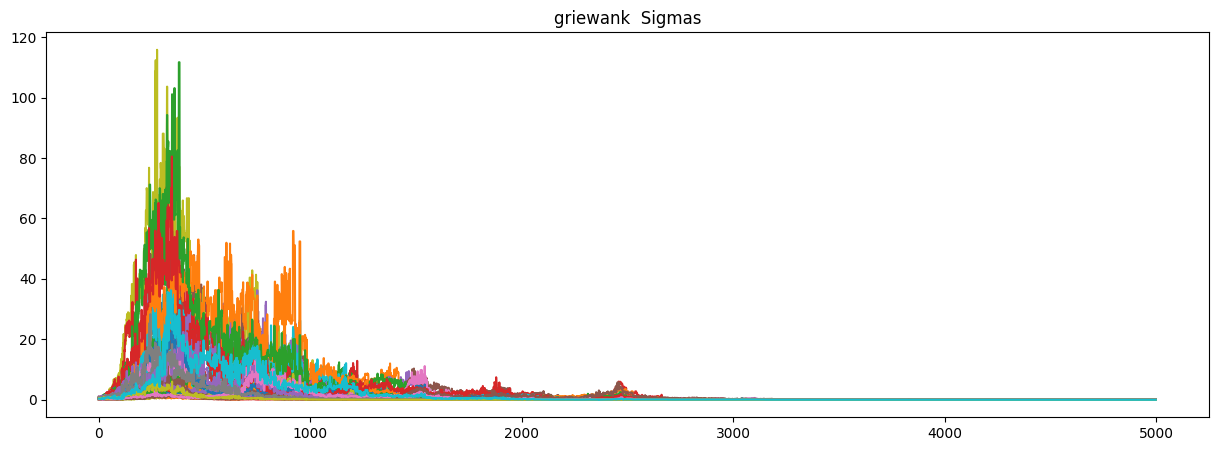

Min: 457.6240903103644


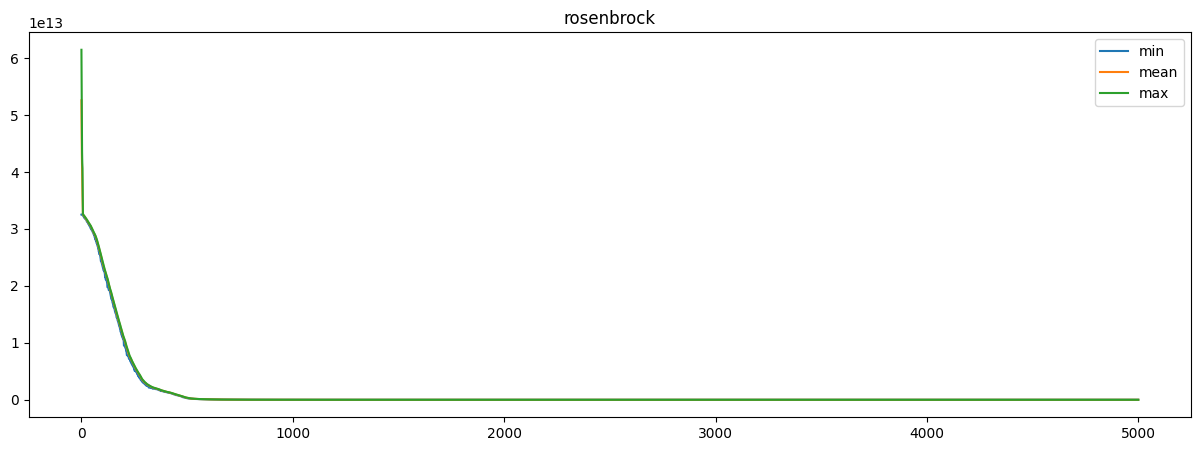

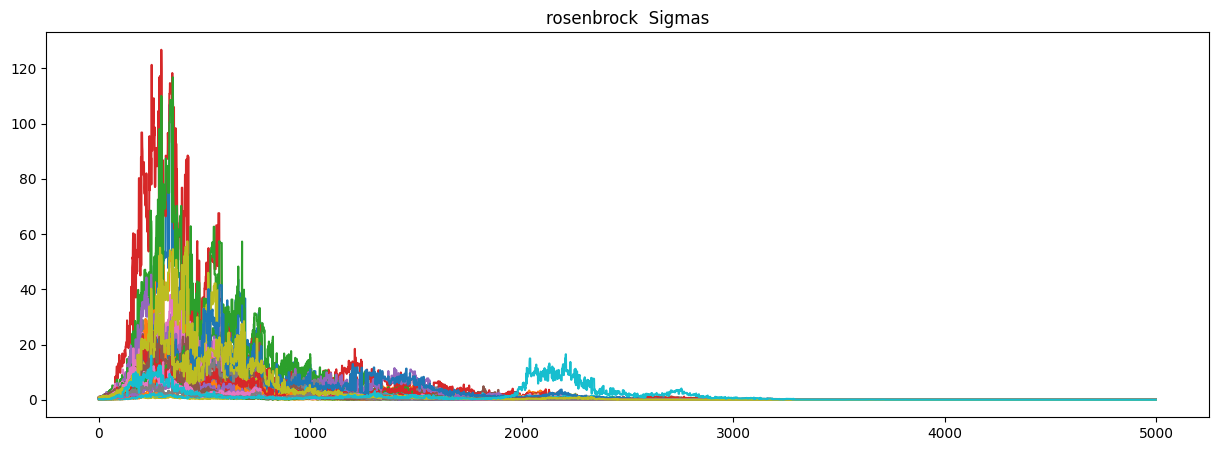

In [235]:
funcs = [sphere, schwefel, rastrigin, griewank, rosenbrock]
for func in funcs:
    p,cost_hist,sigmas_hist = ES(mu=200, lambda_=200, chrom_len=50,dim_size= 50,eval_func=func, N=5000, min_x=-500, max_x=500, K=0.6, plus=True)
    # p_,cost_hist_,sigmas_hist_ = ES(mu=200, lambda_=200, chrom_len=50,dim_size= 50,eval_func=func, N=5000, min_x=-500, max_x=500, K=0.6, plus=False)
    plot_hist(cost_hist, func)
    # plot_hist(cost_hist_, func)
    plot_sigmas(sigmas_hist, func)
    # plot_sigmas(sigmas_hist_, func)
    

Min: 8.118924016637546e+114


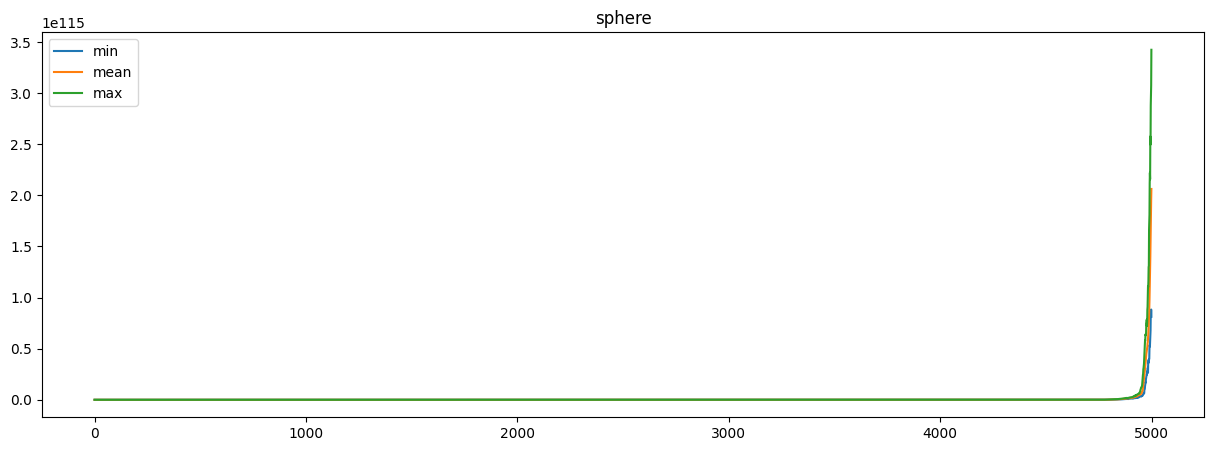

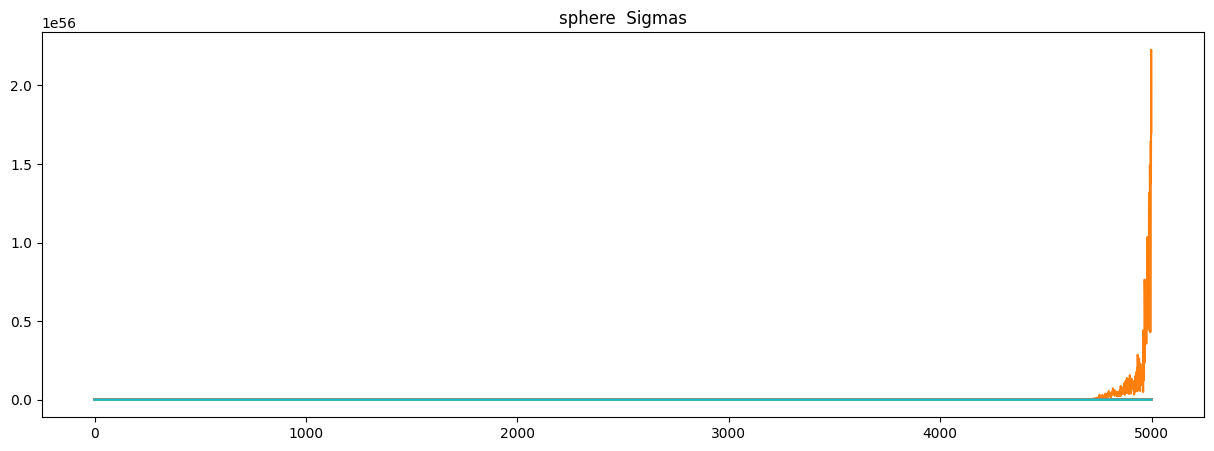

Min: 85842.22746826454


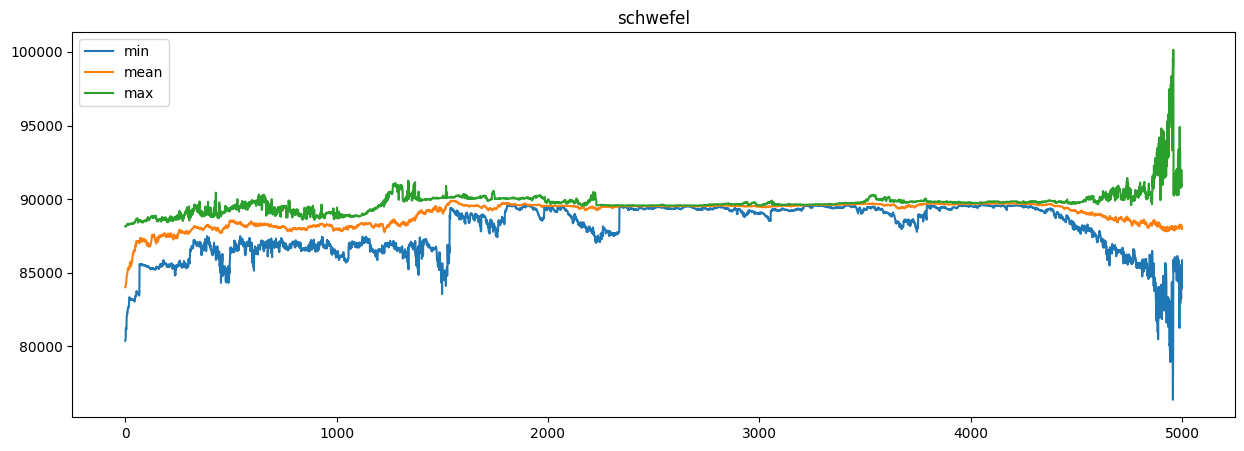

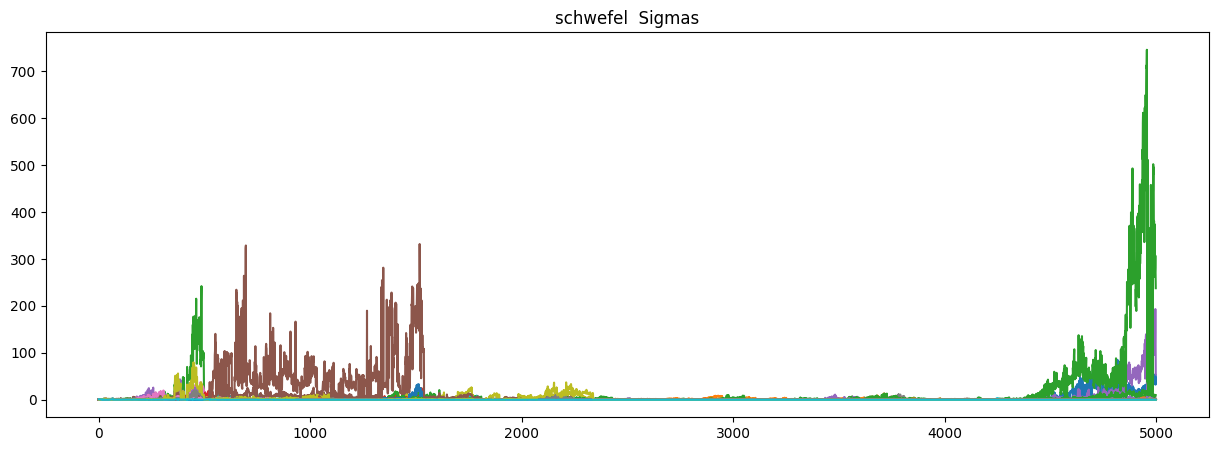

Min: 5.909230361893007e+111


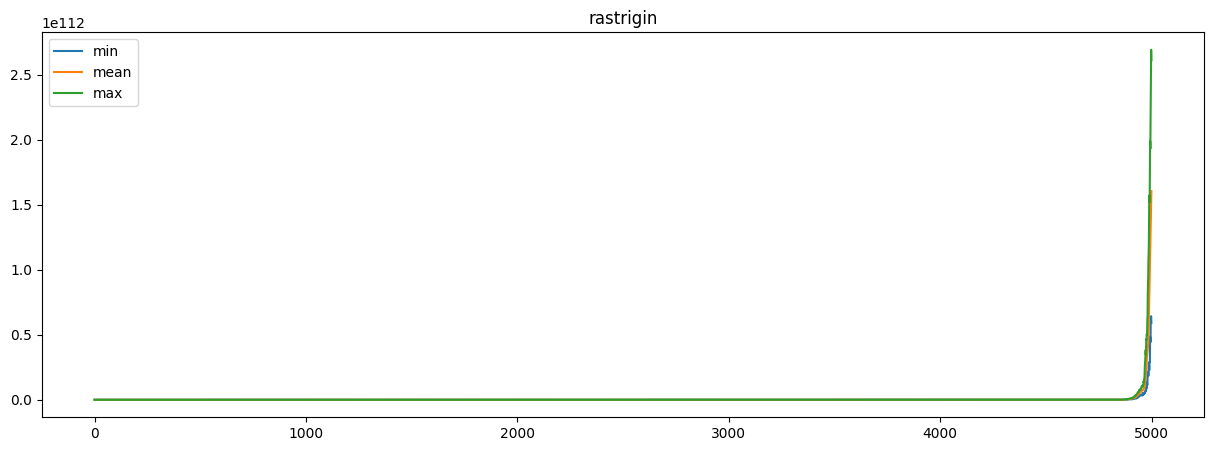

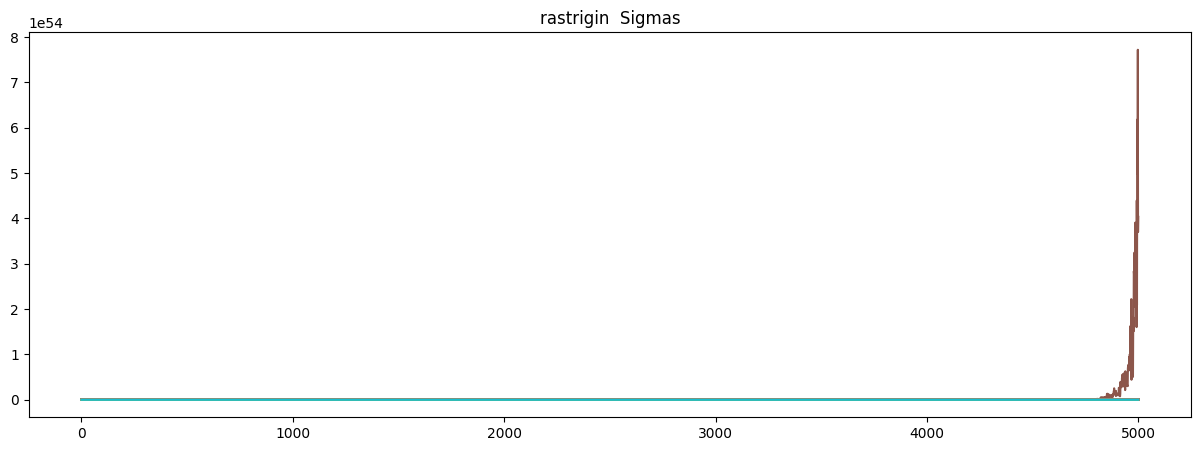

Min: 2.100027806266132e+101


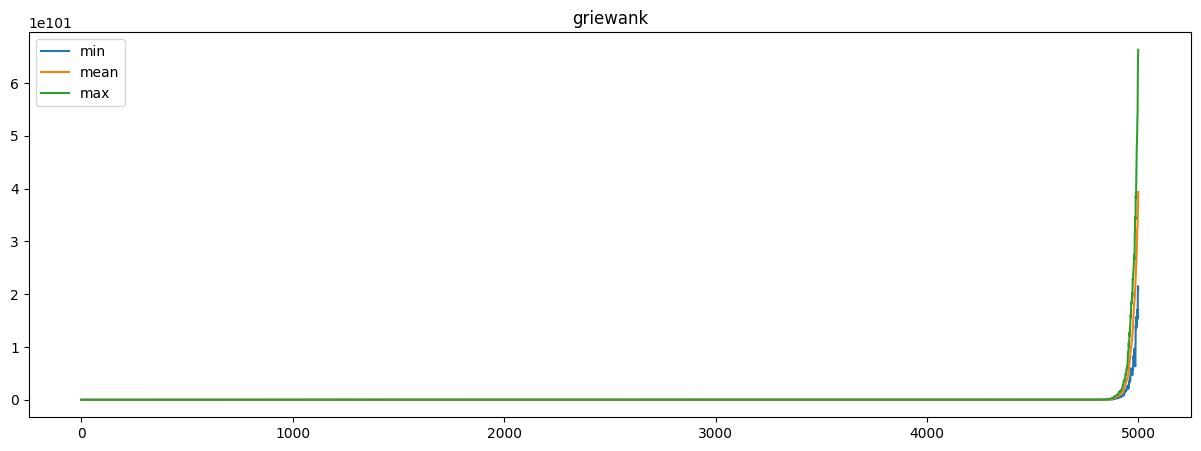

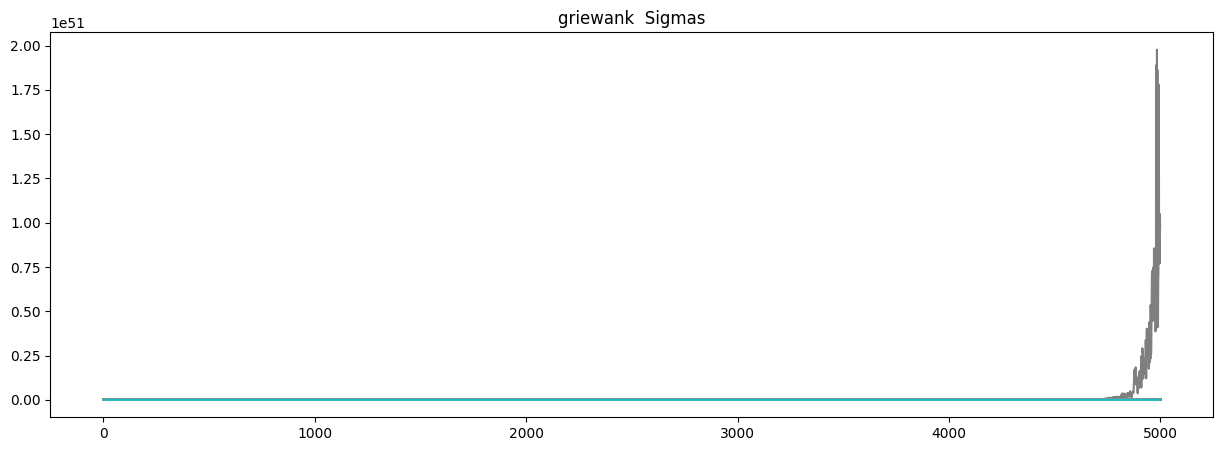

Min: 1.0235334427963951e+278


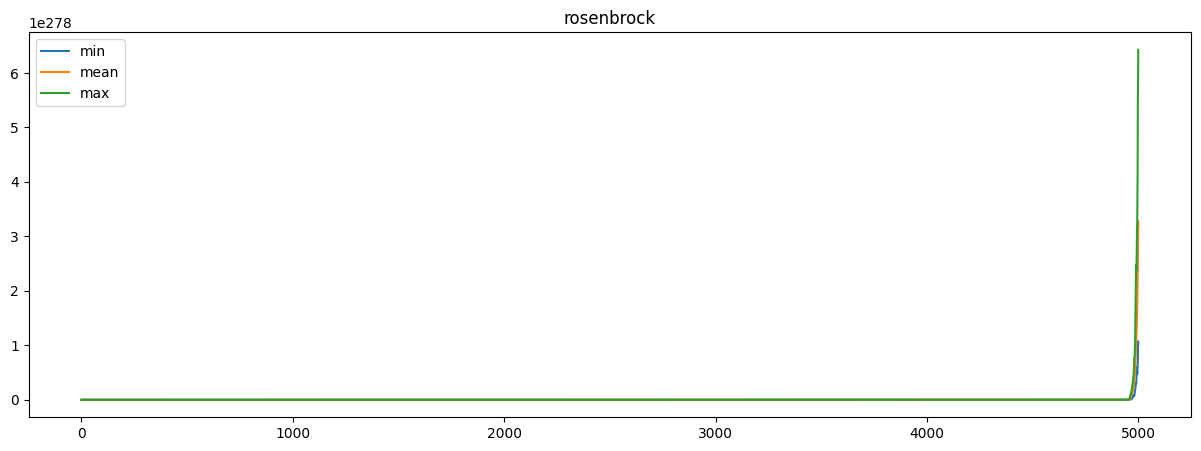

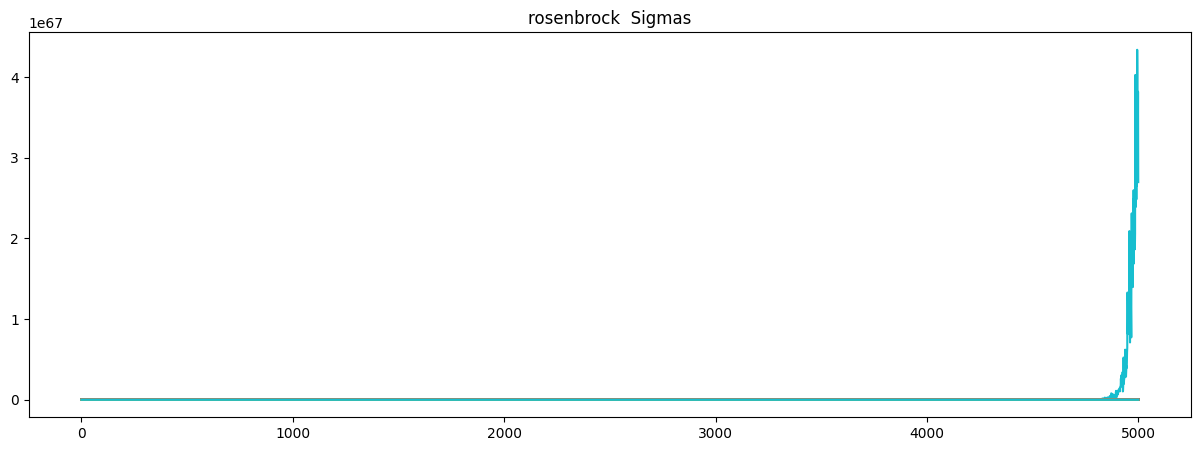

In [242]:
for func in funcs:
    p,cost_hist,sigmas_hist = ES(mu=200, lambda_=200, chrom_len=50,dim_size= 50,eval_func=func, N=5000, min_x=-500, max_x=500, K=0.6, plus=False)
    plot_hist(cost_hist, func)
    plot_sigmas(sigmas_hist, func)
    